# Wine Quality Modelling

A dataset contains chemical characteristics of 6497 different wines, red and white. These characteristics are described numerically by 11 features, like citric acid, alcohol content, and residual sugars. The dataset also contains a quality rating for each wine (1-10), created by sommeliers.

The goal is to model the wine quality based on the physicochemical features provided using machine learning techniques.

(Data source: http://archive.ics.uci.edu/ml/datasets/Wine+Quality,
Paper introducing data: http://www3.dsi.uminho.pt/pcortez/wine5.pdf)

The project is structured in four parts:


1.   Softmax Regression, manual implementation
2.   Neural Network, manual implementation
3.   Neural Network, tensorflow
      *   Adam optimization
      *   Mini batch
      *   Dropout regularization
4.   Support Vector Machines, K-Nearest-Neighbors, sklearn



In [0]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn import svm
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.python.framework import ops
from sklearn.model_selection import KFold
import math

The data consists of two sets, one for red wine and one for white wine, each containing the same describing chemical properties.

The sets are divided in feature (X) and label (y) and the red and white wine sets are concatenated, leaving us with six data arrays:


*  **X_red**, **y_red** --> features and label for the red wine
*   **X_white**, **y_white** --> features and label for the white wine
*   **X**, **y** --> features and label for the concatenated set

The y vectors are transformed into integers to allow the later one-hot transformation. Additionally, the unused labels are removed (see next text box)

In [0]:
# Loading data
url_red = 'http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
url_white = 'http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv'

data_red = np.genfromtxt(url_red, delimiter=';')[1:]
data_white = np.genfromtxt(url_white, delimiter=';')[1:]
feature_names = np.genfromtxt(url_red, delimiter=';', dtype=str, encoding=None)[0]
feature_names = feature_names.reshape((12,1))

X_red, y_red = data_red[:,0:-1], data_red[:,-1]
X_white, y_white = data_white[:,0:-1], data_white[:,-1]
X, y = np.concatenate((X_red, X_white)), np.concatenate((y_red, y_white))

y = y.astype(int)
y -= 3
y_white = y_white.astype(int)
y_white -=3
y_red = y_red.astype(int)
y_red -=3

Striking about the data exploration is the fact that although quality ratings from 0 to 10 are possible, only ratings from 3 to 9 were given. As there is no data available for the classes 1, 2, and 10, the **multiclass problem is (for now) reduced to 7 classes**.

Also striking is the uneven distribution of the quality rating indicating that  a simple network architecture might not be sufficient to solve this problem.

In [0]:
# Data Exploration
print('Number red wines:' + str(X_red.shape[0])) 
print('Number white wines:' + str(X_white.shape[0])) 
print('Number total:' + str(X.shape[0])) 
print('\nFeatures: \n {}' .format(feature_names[0:-1]))
print('\nClasses of wine: {}' .format(np.unique(y+3)))

Number red wines:1599
Number white wines:4898
Number total:6497

Features: 
 [['"fixed acidity"']
 ['"volatile acidity"']
 ['"citric acid"']
 ['"residual sugar"']
 ['"chlorides"']
 ['"free sulfur dioxide"']
 ['"total sulfur dioxide"']
 ['"density"']
 ['"pH"']
 ['"sulphates"']
 ['"alcohol"']]

Classes of wine: [3 4 5 6 7 8 9]


The data is preprocessed by mean and standard deviation normalization, the number of labels was reduced and the data is divided into into training (0.8) and test (0.2) set. This ratio seems adequate considering the small amount of available data. 

In [0]:
# Red data
X_red = stats.zscore(X_red)
X_red_train, X_red_test, y_red_train, y_red_test = train_test_split(X_red, y_red, test_size=0.2)
X_red_train, X_red_test = X_red_train.T, X_red_test.T

# White data
X_white = stats.zscore(X_white)
X_white_train, X_white_test, y_white_train, y_white_test = train_test_split(X_white, y_white, test_size=0.2)
X_white_train, X_white_test = X_white_train.T, X_white_test.T

# Mixed data
X = stats.zscore(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_test = X_train.T, X_test.T

## 1) Logistic regression
In a first attempt to solve the problem a simple one-layer logistic regression network is used. 

An implementation by hand (softmax regression) is shown.

### Manual softmax regression implementation


For this approach the following functions were written:

*   **optimize**: Combining forward pass, backward pass, cost calculation and parameter update, thus optimizing the weights with respect to the chosen number of iterations and learning rate using gradient descent
*   **predict**: Calculates the predicted labels using the trained weights
*   **softmax**: Activation function for the softmax layer
*   **L_softmax**: Determines the multiclass loss using predicted and actual labels
*   **one_hot**: Converts the class label vector into a one-hot matrix to to dteermine the multiclass loss
*   **he_init**: Initializes the weight matrix W according to the method introduced by He et al (https://arxiv.org/abs/1502.01852). Since we're using a softmax and therefore a multi-node output layer a non-zero initialization is necessary to break symmetry.


As we are dealing with a network without hidden layers, softmax remains the only activation function, an implementation of sigmoid and/or (leaky) ReLU is not needed.

In [0]:
# Optimize
def optimize(w, b, X, Y, num_iterations, learning_rate, lambd, print_cost = False):
  
  costs = []
        
  for i in range(num_iterations):

      m = X.shape[1]
      n = Y.shape[0]

      Z = np.dot(w,X) + b
      A = softmax(Z)
      cost = (1/m) * np.sum(L_softmax(A, Y)) 
      cost -= lambd * np.sum(np.square(w)) / (2 * m)

      dw = (1/m) * np.dot(X, (A-Y).T).T
      dw -= (lambd * w) / m
      db = ((1/m) * np.sum(A - Y, axis = 1)).reshape(n,1)

      grads = {"dw": dw, "db": db}
      dw = grads["dw"]
      db = grads["db"]

      w = w - learning_rate * dw
      b = b - learning_rate * db

      if i % 100 == 0:
          costs.append(cost)

      if print_cost and i % 100 == 0:
          print ("Cost after iteration %i: %f" %(i, cost))

  params = {"w": w,
            "b": b}

  grads = {"dw": dw,
           "db": db}

  return params, grads, costs


# Prediction
def predict(w, b, X):
   
  Z = np.dot(w,X) + b
  A = softmax(Z)

  return np.where(A == np.amax(A, 0))[0]


# Softmax
def softmax(x):

  x_exp = np.exp(x)
  x_sum = np.sum(x_exp, axis = 0, keepdims = True)

  return x_exp / x_sum


# Softmax loss
def L_softmax(yhat, y):
  
  hadamard = np.multiply(y, np.log(yhat))
  hadamard[np.isneginf(hadamard)]=0

  return np.nansum(hadamard, axis=0)


# One-hot transformation
def one_hot(a, num_classes):
  
  return np.squeeze(np.eye(num_classes)[a.reshape(-1)])


# He initialization
def he_init(size_1, size_0):

  return np.random.randn(size_1,size_0) * np.sqrt(2/size_0)

To initialize the data for the optimizing function, the weight arrays W and b are created and y is transformed into a one-hot matrix. 

In [0]:
# 1) Initialize
nr_classes = np.unique(y).shape[0]
nr_features = X.shape[1]

y_use = one_hot(y_train, 7).T # transform y into one-hot vectors
W = he_init(nr_classes,nr_features) # use He et al initialization for W
b = np.zeros((nr_classes,1)) # initialize b with zeros

print('Shape y_use: {}' .format(y_use.shape))
print('Shape X_train: {}' .format(X_train.shape))
print('Shape W: {}' .format(W.shape))
print('Shape b: {}' .format(b.shape))

Shape y_use: (7, 5197)
Shape X_train: (11, 5197)
Shape W: (7, 11)
Shape b: (7, 1)


The optimize function is executed to learn the best parameters for W and b. The cost over the iterations shows a steady inclination.

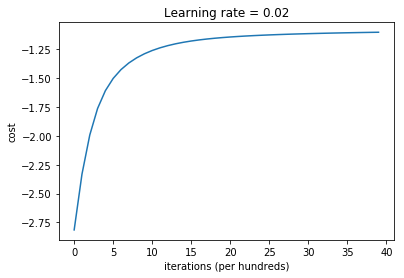

In [0]:
# 2) Run & plot
params, grads, costs = optimize(W, b, X_train, y_use, num_iterations=4000, lambd=0,
                                learning_rate=0.01)
costs = np.squeeze(costs)
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate = 0.02")
plt.show()

A multiclass confusion matrix is created. This makes it easy to compute the accuracy as well as the accuracy for data mislabeled into a neighbouring class.


The expected accuracy for random guesses with 7 classes is 14.3%. The here achieved accuracy for training and test set is **lower than 40%**. This is a bad result, not even every second wine gets labeled correctly. Nevertheless it is above the accuracy for random guessing, showing that the manual implementation works. And the accuracy for examples labeled into a neighbouring class is quite high with almost 90%.

As accuracies for both sets are similar we don't face a problem of overfitting. In addition to the flattened out cost curve after 2000 iterations, which shows that the computational power of the logistic regression is exploited. It can be concluded that a one layer network is not suitable to face the wine classification. Following this intense hyperparameter tuning and polynomial prediction was waived, since the result using this architecture would not be satisfying in any case.

In [0]:
# 3) Determine accuracy
y_pred_train = predict(params['w'], params['b'], X_train)
y_pred_test = predict(params['w'], params['b'], X_test)
labels=[0, 1, 2, 3, 4, 5, 6, 7]

cm_train = confusion_matrix(y_train, y_pred_train, labels=labels)
cm_test = confusion_matrix(y_test, y_pred_test, labels=labels)
with_offset_train = np.trace(cm_train) + np.trace(cm_train, offset=1) + np.trace(cm_train, offset=-1)
with_offset_test = np.trace(cm_test) + np.trace(cm_test, offset=1) + np.trace(cm_test, offset=-1)

print('Accuracy training set: {0:.2f}%' .format((np.trace(cm_train) / np.sum(cm_train)) * 100)) 
print('Accuracy validation set: {0:.2f}%' .format((np.trace(cm_test) / np.sum(cm_test)) * 100))

print('\nAccuracy training set including offset +-1: {0:.2f}%' .format((with_offset_train / np.sum(cm_train)) * 100))
print('Accuracy validation set including offset +-1: {0:.2f}%' .format((with_offset_test / np.sum(cm_test)) * 100))

Accuracy training set: 38.62%
Accuracy validation set: 38.46%

Accuracy training set including offset +-1: 87.09%
Accuracy validation set including offset +-1: 85.92%


## 2) Neural Networks
As concluded in section 1), the wine classification requires a more complex architecture. Thus, this section looks into the application of neural networks. Similar to the previous section, first, a manual implementation of a neural network is tested. Second, an implementation using the programming framework tensorflow is carried out.

### 2-hidden layer manual implementaion


For this approach the following functions were written:


*   **relu:** Implememts the ReLU activation function
*   **relu_backwards:** Implements the derivation of the ReLU function
*   **init_weights:** Initializes the weight matrices W and bis vectors b using the He-Initialization
*   **forward_propagation:** Computes the forward computation graph
*   **backward_propagation:** Computes the backward computation graph
*   **update_weights:** Updates the weight parameters using the derivations of the backward propagation
*   **model:** Puts the above described functions together in an executable model training a 2-hidden layer neural network using gradient descent optimization and softmax output.




In [0]:
# ReLU
def relu(z):
  
  return np.maximum(0,z)

# ReLU backwards
def relu_backwards(z):
  
    z[z<=0] = 0
    z[z>0] = 1
    
    return z
  
# Initializing weights
def init_weights(layer_vec):
  
  L = layer_vec.shape[0] - 1
  weights = {}
  
  for i in range(L):
    W = he_init(layer_vec[i+1], layer_vec[i])
    b = np.zeros((layer_vec[i+1], 1))
    
    weights.update({"W" + str(i+1): W,
                    "b" + str(i+1): b})
  
  return weights

# Forward prop
def forward_propagation(X, weights):
    W1 = weights['W1']
    b1 = weights['b1']
    W2 = weights['W2']
    b2 = weights['b2']
    W3 = weights['W3']
    b3 = weights['b3']

    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    Z3 = np.dot(W3, A2) + b3
    A3 = softmax(Z3)
        
    cache = {'Z1': Z1,
             'A1': A1,
             'Z2': Z2,
             'A2': A2,
             'Z3': Z3,
             'A3': A3,}
    
    return A3, cache

# Back prop  
def backward_propagation(weights, cache, X, Y):

    m = X.shape[1]
    
    W1 = weights['W1']
    W2 = weights['W2']
    W3 = weights['W3']
        
    A1 = cache['A1']
    A2 = cache['A2']
    A3 = cache['A3']
    
    dZ3 = A3 - Y
    dW3 = (1/m) * np.dot(A2, (dZ3).T).T
    db3 = (1/m) * np.sum(dZ3, axis=1, keepdims=True)
    dZ2 = relu_backwards(A2)
    dW2 = (1/m) * np.dot(A1, (dZ2).T).T
    db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = relu_backwards(A1)
    dW1 = (1/m) * np.dot(X, (dZ1).T).T
    db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)
    
    grads = {'dW1': dW1,
             'db1': db1,
             'dW2': dW2,
             'db2': db2,
             'dW3': dW3,
             'db3': db3}
    
    return grads
  
# Parameter update
def update_weights(weights, grads, learning_rate):

    W1 = weights['W1']
    b1 = weights['b1']
    W2 = weights['W2']
    b2 = weights['b2']
    W3 = weights['W3']
    b3 = weights['b3']

    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']
    dW3 = grads['dW3']
    db3 = grads['db3']

    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    W3 = W3 - learning_rate * dW3
    b3 = b3 - learning_rate * db3

    weights = {'W1': W1,
               'b1': b1,
               'W2': W2,
               'b2': b2,
               'W3': W3,
               'b3': b3}
    
    return weights
  
# Put it all together
def model(X, y, layer_vec, num_iterations, learning_rate):
  
  weights = init_weights(layer_vec)
  m = X.shape[1]
  costs = []
  
  for i in range(num_iterations):
    A3, cache = forward_propagation(X, weights)
    cost = (1/m) * np.sum(L_softmax(A3, y)) 
    grads = backward_propagation(weights, cache, X, y)
    weights = update_weights(weights, grads, learning_rate)
    
    if i % 100 == 0:
          costs.append(cost)
                
  return weights, grads, costs

A neural network with the following architecture is tested:
*   Input layer: 11 nodes
*   hidden layer 1: 15 nodes
*   hidden layer 2: 12 nodes
*   softmax output: 7 nodes

This is not a fine tuned architecture, it serves the purpose of giving a first overview of a neural network in comparison to the logistic regression implementation. Further will be said in the next section.

The cost curve shows steady inclination, indicating that the implementation works as expected.

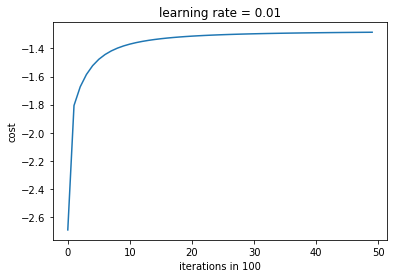

In [0]:
layer_vec = np.array([11, 15, 12, 7])
l_rate = 0.01

weights, grads, costs = model(X_train, y_use, layer_vec = layer_vec, num_iterations=5000, learning_rate=l_rate)

plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations in 100')
plt.title('learning rate = ' + str(l_rate))
plt.show()

The following code computes the accuracy of training and validation set. It is shown that the neural network provides an increased accuracy compared to the logistic regression used above.

In [0]:
y_pred_train = forward_propagation(X_train, weights)[0]
y_pred_train = np.where(y_pred_train == np.amax(y_pred_train, 0))[0]
y_pred_test = forward_propagation(X_test, weights)[0]
y_pred_test = np.where(y_pred_test == np.amax(y_pred_test, 0))[0]
labels=[0, 1, 2, 3, 4, 5, 6, 7]

cm_train = confusion_matrix(y_train, y_pred_train, labels=labels)
cm_test = confusion_matrix(y_test, y_pred_test, labels=labels)


print('Accuracy training set: {0:.2f}%' .format((np.trace(cm_train) / np.sum(cm_train)) * 100)) 
print('Accuracy validation set: {0:.2f}%' .format((np.trace(cm_test) / np.sum(cm_test)) * 100))

Accuracy training set: 43.66%
Accuracy validation set: 43.62%


### 2-hidden layer tensorflow implementaion

In a second attempt a neural network is implemented in tensorflow to ease the use of further machine learning techniques and increase the validation set accuracy.

To make use of the programming framework tensorflow the following functions are introduced:



*   **forward_propagation:** Computes the forward computation graph of the neural network. This includes the dropout layers responsible for the regularization. ReLU is used as activation
*   **one_hot_matrix:** Serves the same function as the already introduced **one_hot** function, but makes use of the implemented function in tensorflow
*   **create_placeholders:** Creates placeholders that are used in the computation graph and are filled with values to execute said graph. In this case the function is used to create placeholders for X and Y
*   **initialize_parameters:** Initializes the weight matrices W and bias vectors b, and therefore the network architecture is determined here. To increase the performance of the neural network the Xavier-initialization is used (http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)
*   **random_mini_batches:** to increase the computational speed of the neural network mini batches are used, which are randomly initialized using this function
*   **compute_cost:** computes the cross entropy loss
*   **model:** combines the functions introduced above to run a neural network using dropout regularization, mini batches, and Adam optimization.


In [0]:
def forward_propagation(X, parameters, dropout_rate):

    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.add(tf.matmul(W1, tf.nn.dropout(X,rate=dropout_rate)), b1)
    A1 = tf.nn.relu(Z1)
    Z2 = tf.add(tf.matmul(W2, tf.nn.dropout(A1,rate=dropout_rate)), b2)
    A2 = tf.nn.relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)
    
    return Z3
  
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1000, minibatch_size = 32, print_cost = True, dropout_rate = 0, plot = True):

    ops.reset_default_graph()
    (n_x, m) = X_train.shape
    n_y = Y_train.shape[0]
    costs = [] 
    costs_test = []

    X, Y = create_placeholders(n_x, n_y)
    parameters = initialize_parameters()

    Z = forward_propagation(X, parameters, dropout_rate)
    cost = compute_cost(Z, Y)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    init = tf.global_variables_initializer()

    with tf.Session() as sess:
      
        sess.run(init)
        
        for epoch in range(num_epochs):

            epoch_cost = 0.
            num_minibatches = int(m / minibatch_size)
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size)

            for minibatch in minibatches:

                (minibatch_X, minibatch_Y) = minibatch

                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatches
                
            epoche_cost_test = sess.run(cost, feed_dict={X: X_test, Y: Y_test})
            
#             if print_cost == True and epoch % 100 == 0:
#             	print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if epoch % 5 == 0:
                costs.append(epoch_cost)
                costs_test.append(epoche_cost_test)
                
        if plot == True:     
          plt.plot(np.squeeze(costs), label='Train')
          plt.plot(np.squeeze(costs_test), label='Validation')
          plt.ylabel('cost')
          plt.xlabel('iterations (per tens)')
          plt.title("Learning rate =" + str(learning_rate))
          plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
          plt.show()

        parameters = sess.run(parameters)

        correct_prediction = tf.equal(tf.argmax(Z), tf.argmax(Y))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        acc_train = accuracy.eval({X: X_train, Y: Y_train})
        acc_val = accuracy.eval({X: X_test, Y: Y_test})
        
        scores = {"cost_train" : epoch_cost,
                  "cost_val" : epoche_cost_test,
                  "acc_train" : acc_train,
                  "acc_val" : acc_val}
        
        return parameters, scores

def one_hot_matrix(labels, C):

    C = tf.constant(C, name='C')

    one_hot_matrix = tf.one_hot(indices=labels, depth=C, axis=0)

    sess = tf.Session()

    one_hot = sess.run(one_hot_matrix)

    sess.close()

    return one_hot
  
def create_placeholders(n_x, n_y):

    X = tf.placeholder(tf.float32, [n_x, None], name="X")
    Y = tf.placeholder(tf.float32, [n_y, None], name="Y")
    
    return X, Y
  
def initialize_parameters():

    W1 = tf.get_variable("W1", [20, 11], initializer = tf.contrib.layers.xavier_initializer())
    b1 = tf.get_variable("b1", [20, 1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [14, 20], initializer = tf.contrib.layers.xavier_initializer())
    b2 = tf.get_variable("b2", [14, 1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [7, 14], initializer = tf.contrib.layers.xavier_initializer())
    b3 = tf.get_variable("b3", [7, 1], initializer = tf.zeros_initializer())

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters
  
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):

    m = X.shape[1]
    mini_batches = []
    np.random.seed(seed)
    
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    num_complete_minibatches = math.floor(m/mini_batch_size)
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches
  
def compute_cost(Z, Y):

    logits = tf.transpose(Z)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    
    return cost

In [0]:
y_red_train = one_hot_matrix(y_red_train, 7)
y_red_test = one_hot_matrix(y_red_test, 7)
y_white_train = one_hot_matrix(y_white_train, 7)
y_white_test = one_hot_matrix(y_white_test, 7)
y_train = one_hot_matrix(y_train, 7)
y_test = one_hot_matrix(y_test, 7)

In a first step, a network architecture is chosen. Goal is too slightly overfit each training set, to be sure the networks computing provides enough complexity to be up to the task of fitting the data. 

The following architecture has proven to provide sufficient complexity:


*   Input layer: 11 nodes
*   hidden layer 1: 20 nodes
*   hidden layer 2: 14 nodes
*   softmax output: 7 nodes


The overfitting can be seen in the learning curves for each data set, as by increasing number of iterations the training set costs decrease and the validation set costs increase. Since it is harder to overfit bigger data sets, the here shown overfit decreases by increasing data set size.


Red Wine


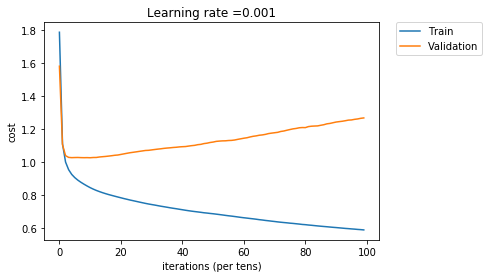

White Wine


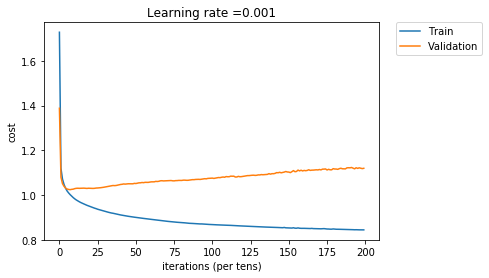

Mixed Wine


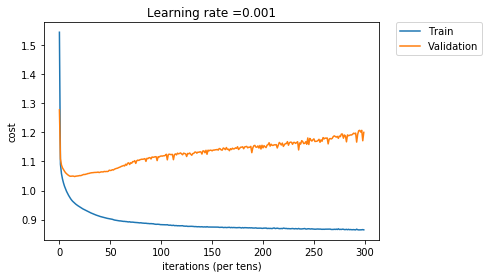

In [0]:
print('Red Wine')
parameters = model(X_red_train, y_red_train, X_red_test, y_red_test, num_epochs = 500, learning_rate = 0.001)
print('White Wine')
parameters = model(X_white_train, y_white_train, X_white_test, y_white_test, num_epochs = 1000, learning_rate = 0.001)
print('Mixed Wine')
parameters = model(X_train, y_train, X_test, y_test, num_epochs = 1500, learning_rate = 0.001)

For each dataset (red, white, mixed) the regulizing parameter is fine tuned to achieve the lowest cost on the validation set. The cost for training and validation set for different dropout rates is depicted.

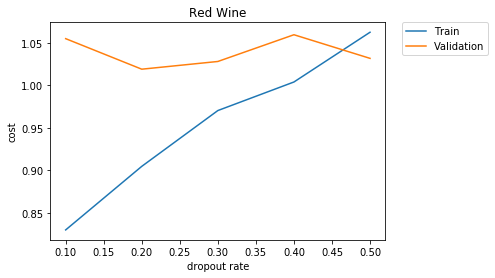

In [0]:
rates = [0.1, 0.2, 0.3, 0.4, 0.5]
costs_train = []
costs_val = []

for rate in rates:
  _, scores = model(X_red_train, y_red_train, X_red_test, y_red_test, num_epochs = 500, learning_rate = 0.001, dropout_rate = rate, plot = False)
  costs_train.append(scores['cost_train'])
  costs_val.append(scores['cost_val'])
  
plt.plot(np.squeeze(rates), np.squeeze(costs_train), label='Train')
plt.plot(np.squeeze(rates), np.squeeze(costs_val), label='Validation')
plt.ylabel('cost')
plt.xlabel('dropout rate')
plt.title("Red Wine")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

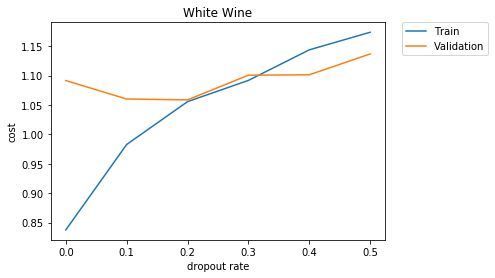

In [0]:
rates = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
costs_train = []
costs_val = []

for rate in rates:
  _, scores = model(X_white_train, y_white_train, X_white_test, y_white_test, num_epochs = 1000, learning_rate = 0.001, dropout_rate = rate, plot = False)
  costs_train.append(scores['cost_train'])
  costs_val.append(scores['cost_val'])
  
plt.plot(np.squeeze(rates), np.squeeze(costs_train), label='Train')
plt.plot(np.squeeze(rates), np.squeeze(costs_val), label='Validation')
plt.ylabel('cost')
plt.xlabel('dropout rate')
plt.title("White Wine")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

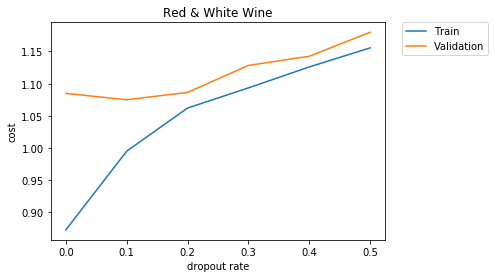

In [0]:
rates = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
costs_train = []
costs_val = []

for rate in rates:
  _, scores = model(X_train, y_train, X_test, y_test, num_epochs = 1500, learning_rate = 0.001, dropout_rate = rate, plot = False)
  costs_train.append(scores['cost_train'])
  costs_val.append(scores['cost_val'])
  
plt.plot(np.squeeze(rates), np.squeeze(costs_train), label='Train')
plt.plot(np.squeeze(rates), np.squeeze(costs_val), label='Validation')
plt.ylabel('cost')
plt.xlabel('dropout rate')
plt.title("Red & White Wine")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

For the red wine set a dropout rate of 0.3 shows the best result. Fot the white and mixed sets a drop out rate of 0.1 seems appropriate. Furthermore the dropout rate could be tuned to an even more precise value by repeating the last step in smaller gradiations around the best rate for each set. However, the achieved results fullfill the needs of this project, therefore this extra step will not be carried out.

Now knowing an appropriate architecture and regularization for each data set, the accuracy is determined at more epoches and a smaller learning rate using 3-fold cross validation.

In [0]:
kf = KFold(n_splits=3, shuffle = True)
train_acc = 0
val_acc = 0
    
for train_index, test_index in kf.split(X_red):
    X_red_train, X_red_test = X_red[train_index].T, X_red[test_index].T
    y_red_train, y_red_test = y_red[train_index], y_red[test_index]
    y_red_train = one_hot_matrix(y_red_train, 7)
    y_red_test = one_hot_matrix(y_red_test, 7)
    
    _, scores = model(X_red_train, y_red_train, X_red_test, y_red_test, num_epochs = 1000, learning_rate = 0.0001, dropout_rate = 0.3, plot = False)
    train_acc += scores['acc_train']
    val_acc += scores['acc_val']
    
print('Red Wine:')
print('Training set accuracy: {0:.2f}' .format(train_acc/3))
print('Validation set accuracy: {0:.2f}' .format(val_acc/3))

Red Wine:
Training set accuracy: 0.57
Validation set accuracy: 0.55


In [0]:
kf = KFold(n_splits=3, shuffle = True)
train_acc = 0
val_acc = 0
    
for train_index, test_index in kf.split(X_white):
    X_white_train, X_white_test = X_white[train_index].T, X_white[test_index].T
    y_white_train, y_white_test = y_white[train_index], y_white[test_index]
    y_white_train = one_hot_matrix(y_white_train, 7)
    y_white_test = one_hot_matrix(y_white_test, 7)
    
    _, scores = model(X_white_train, y_white_train, X_white_test, y_white_test, num_epochs = 2000, learning_rate = 0.0001, dropout_rate = 0.1, plot = False)
    train_acc += scores['acc_train']
    val_acc += scores['acc_val']
    
print('White Wine:')
print('Training set accuracy: {0:.2f}' .format(train_acc/3))
print('Validation set accuracy: {0:.2f}' .format(val_acc/3))

White Wine:
Training set accuracy: 0.57
Validation set accuracy: 0.54


In [0]:
kf = KFold(n_splits=3, shuffle = True)
train_acc = 0
val_acc = 0
    
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index].T, X[test_index].T
    y_train, y_test = y[train_index], y[test_index]
    y_train = one_hot_matrix(y_train, 7)
    y_test = one_hot_matrix(y_test, 7)
    
    _, scores = model(X_train, y_train, X_test, y_test, num_epochs = 3000, learning_rate = 0.0001, dropout_rate = 0.1, plot = False)
    train_acc += scores['acc_train']
    val_acc += scores['acc_val']
    
print('Mixed Wine:')
print('Training set accuracy: {0:.2f}' .format(train_acc/3))
print('Validation set accuracy: {0:.2f}' .format(val_acc/3))

Mixed Wine:
Training set accuracy: 0.57
Validation set accuracy: 0.55


The tensorflow neural network shows a better result than the logistic regression and the manually implemented NN .

## 3) SVM & KNN
As a final part of the project the Support Vector Machine and K-Nearest-Neighbor methods are applied to the data sets. This is implemented using sklearn.

In [0]:
X_train, X_test = X_train.T, X_test.T
X_red_train, X_red_test = X_red_train.T, X_red_test.T
X_white_train, X_white_test = X_white_train.T, X_white_test.T

In [0]:
print('SVM:')
clf = svm.SVC(kernel="linear", C=5)
clf.fit(X_red_train, y_red_train)
acc = metrics.accuracy_score(y_red_test, clf.predict(X_red_test))
print('Red Wine: {0:.2f}' .format(acc))
clf.fit(X_white_train, y_white_train)
acc = metrics.accuracy_score(y_white_test, clf.predict(X_white_test))
print('White Wine: {0:.2f}' .format(acc))
clf.fit(X_train, y_train)
acc = metrics.accuracy_score(y_test, clf.predict(X_test))
print('Mixed Wine: {0:.2f}' .format(acc))

SVM:
Red Wine: 0.55
White Wine: 0.52
Mixed Wine: 0.53


In [0]:
print('KNN:')
clf = KNeighborsClassifier(n_neighbors=10, weights='distance')
clf.fit(X_red_train, y_red_train)
acc = metrics.accuracy_score(y_red_test, clf.predict(X_red_test))
print('Red Wine: {0:.2f}' .format(acc))
clf.fit(X_white_train, y_white_train)
acc = metrics.accuracy_score(y_white_test, clf.predict(X_white_test))
print('White Wine: {0:.2f}' .format(acc))
clf.fit(X_train, y_train)
acc = metrics.accuracy_score(y_test, clf.predict(X_test))
print('Mixed Wine: {0:.2f}' .format(acc))

KNN:
Red Wine: 0.65
White Wine: 0.65
Mixed Wine: 0.67


The KNN provides the most accurate method. Interestingly the the mixed data provides a higher accuracy than the splitted data sets. This could be due to the missing fine tuning of the hyperparameter.

Also notable is that the accuracy for white wine matches the accuracy presented in the paper whereas the red wine accuracy outscores the paper by several points.

In a next step the accuracy could further be analyzed, meaning it could be observed which label was predicted how accurate, how does the accuracy change with changing tolerance, and the hyperparameter of the KNN method could be fine-tuned. The goal of this project, however, was to gain overview of different ML methods, which was at this point successfully achieved.